In [1]:
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
pd.options.display.max_columns = None
#from pybaseball import batting_stats, batting_stats_range, pitching_stats_range, cache, playerid_lookup, statcast_batter, statcast_pitcher, statcast
import math
import sqlite3
#from fantasy_utils import Fantasy_Projections
import fantasy_utils as fu
import optimize_lineup as ol
import time
#cache.enable()
#cache.config.cache_type='csv'
#cache.config.save()

In [2]:
fp = fu.Fantasy_Projections()
#df = fp.make_projections(fp.yr)

In [3]:
conn = sqlite3.connect('fantasy_data.db')
conn.create_function('sqrt', 1, math.sqrt)
cursor = conn.cursor()

In [4]:
#keepers Google doc
keepers_url = 'https://docs.google.com/spreadsheets/d/1dwDC2uMsfVRYeDECKLI0Mm_QonxkZvTkZTfBgnZo7-Q/edit#gid=1723951361'

In [5]:
from sqlalchemy import MetaData, text, Column, Integer, String, ForeignKey, Table, create_engine, Float, Boolean, DateTime
from sqlalchemy.orm import relationship, backref, sessionmaker
from sqlalchemy.orm import declarative_base

meta = MetaData()
engine = create_engine('sqlite:///fantasy_data.db', echo=False)
Session = sessionmaker(bind=engine)
session = Session()
Base = declarative_base()

In [6]:
ids = fp.load_id_map()

In [7]:
owner_dict = {"owner_id":[30, 3, 36, 41, 4, 27, 38, 44, 1, 29, 42, 45],
              "owner":["9 Grand Kids", 'Brewbirds', 'Charmer', 'Dirty Birds', "Harveys Wallbangers", 'Lil Trump & the Ivanabees', 'Lima Time!', 'Roid Ragers', 'Trouble with the Curve', 'Ugly Spuds', 'Wiscompton Wu-Tang', 'Young Guns'],
             }

In [8]:
pd.read_sql("SELECT name FROM sqlite_master", engine)

,name
0,hitting
1,ix_hitting_index
2,hitters
3,sqlite_autoindex_hitters_1
4,players2022
5,owners
6,drafted
7,roster
8,stats
9,players2023


In [9]:
position_priority = ['posC', 'pos2B', 'pos3B', 'posSS', 'posOF', 'pos1B', 'posMI', 'posCI', 'posDH', 'posSP', 'posRP']
def stitch_positions(row):
    pos_code = row[position_priority+['posP']]>=1
    return str([i.replace('pos','') for i in list(pos_code[pos_code].index)])

### optimized lineups

In [10]:
pd.read_sql("SELECT * FROM vw_player_week_z WHERE year=2025 ORDER BY z desc limit 12 offset 20", conn)

DatabaseError: Execution failed on sql 'SELECT * FROM vw_player_week_z WHERE year=2025 ORDER BY z desc limit 12 offset 20': user-defined function raised exception

In [13]:
weekly_lineup_rating = {}

In [11]:
tm = '9 Grand Kids'
a = pd.read_sql(f"SELECT r.year, r.week, r.cbsid, COALESCE(p.CBSNAME,'unknown') Player, COALESCE(o.owner,'FA') Owner, \
    r.pos, COALESCE(z.z,-9) z, all_pos \
    FROM roster r \
    LEFT JOIN players p On (r.cbsid=p.cbsid) \
    LEFT JOIN owners o On (r.owner_id=o.owner_id) \
    LEFT JOIN vw_player_week_z z On (z.cbsid=r.cbsid AND z.year=r.year AND z.week=r.week) \
    LEFT JOIN eligibility e On (e.cbsid=r.cbsid AND e.year=r.year AND e.week=r.week) \
    WHERE o.owner='{tm}' and r.year=2025", conn)
a['type'] = a['all_pos'].apply(lambda x: 'h' if 'DH' in x else 'p')

DatabaseError: Execution failed on sql 'SELECT r.year, r.week, r.cbsid, COALESCE(p.CBSNAME,'unknown') Player, COALESCE(o.owner,'FA') Owner,     r.pos, COALESCE(z.z,-9) z, all_pos     FROM roster r     LEFT JOIN players p On (r.cbsid=p.cbsid)     LEFT JOIN owners o On (r.owner_id=o.owner_id)     LEFT JOIN vw_player_week_z z On (z.cbsid=r.cbsid AND z.year=r.year AND z.week=r.week)     LEFT JOIN eligibility e On (e.cbsid=r.cbsid AND e.year=r.year AND e.week=r.week)     WHERE o.owner='9 Grand Kids' and r.year=2025': user-defined function raised exception

In [12]:
pd.pivot_table(a, columns='week', aggfunc='count', values='cbsid')

week,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0
cbsid,49,54,53,57,55,54,56,58,60,60,61,59,59,30,30,25,28,28,27,26,27,27,24,30,29,27,25


In [17]:
b = pd.read_sql(f"SELECT COALESCE(p.cbsname,'not known') Player, COALESCE(o.owner, 'FA') Owner, \
    r.*, COALESCE(z.z,-9) z, e.all_pos \
    FROM roster r \
    LEFT JOIN players p On (r.cbsid=p.cbsid) \
    LEFT JOIN owners o On (r.owner_id=o.owner_id) \
    LEFT JOIN vw_player_week_z z On (z.cbsid=r.cbsid AND z.year=r.year AND z.week=r.week) \
    LEFT JOIN eligibility e On (e.cbsid=r.cbsid AND e.year=r.year AND e.week=r.week) \
    WHERE o.owner='{tm}'", conn)
b['type'] = b['all_pos'].apply(lambda x: 'h' if 'DH' in x else 'p')
b

DatabaseError: Execution failed on sql 'SELECT COALESCE(p.cbsname,'not known') Player, COALESCE(o.owner, 'FA') Owner,     r.*, COALESCE(z.z,-9) z, e.all_pos     FROM roster r     LEFT JOIN players p On (r.cbsid=p.cbsid)     LEFT JOIN owners o On (r.owner_id=o.owner_id)     LEFT JOIN vw_player_week_z z On (z.cbsid=r.cbsid AND z.year=r.year AND z.week=r.week)     LEFT JOIN eligibility e On (e.cbsid=r.cbsid AND e.year=r.year AND e.week=r.week)     WHERE o.owner='Young Guns'': user-defined function raised exception

In [ ]:
pd.pivot_table(b, columns='week', aggfunc='count', values='cbsid')

In [273]:
#cursor.execute("INSERT INTO roster VALUES (26615381, 4, 2023, 27, 'DH')")
#cursor.execute("INSERT INTO eligibility VALUES (26615381, 2023, 26, \"['OF', 'DH']\", 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0)")
#cursor.execute("DELETE FROM eligibility WHERE cbsid=26615381 and week=26")
#cursor.execute("UPDATE eligibility SET all_pos=\"['C', 'OF', 'DH']\", posC=1 WHERE cbsid=26719539")

In [297]:
weekly_lineup_rating[tm] = []

for wk in range(1,28):
    p_score = b[(b['pos']!='B') & (b['week']==wk)].z.sum()
    #assert a[a['pos']!='B'].shape[0] == 23
    #assert a.shape[0] == 33

    opt = ol.Optimized_Lineups(tm, b[b['week']==wk])
    opt._make_hitter_combos()
    opt._make_pitcher_combos()
    opt_score = opt.hitter_optimized_z + opt.pitcher_optimized_z
    #print(opt_score)
    print(f"Week {wk}: {round(p_score/opt_score,2)}")
    weekly_lineup_rating[tm].append({'week':wk, 'score':p_score, 'optimal':opt_score, 'rating':round(p_score/opt_score,2)})

Week 1: 0.4
Week 2: 0.82
Week 3: 0.65
Week 4: 0.57
Week 5: 0.43
Week 6: 0.89
Week 7: 0.35
Week 8: 0.3
Week 9: 0.69
Week 10: 0.67
Week 11: 0.27
Week 12: 0.57
Week 13: 0.64
Week 14: 0.8
Week 15: 0.56
Week 16: -0.03
Week 17: 0.27
Week 18: -1.38
Week 19: 0.28
Week 20: -4.92
Week 21: -0.76
Week 22: 140.2
Week 23: 0.4
Week 24: 0.83
Week 25: 0.71
Week 26: 0.68
Week 27: 0.58


In [141]:
#cursor.execute("UPDATE eligibility SET posC=1 WHERE cbsid=2164748")
#cursor.execute('UPDATE eligibility SET all_pos = "[\'C\', \'DH\']" WHERE cbsid=2164748')
#cursor.execute('DELETE FROM roster WHERE cbsid=29075539 AND pos="DH" AND week>=26')
#conn.commit()

In [191]:
max_z = -999
max_z_idx = -1
for num in range(len(position_combos)):
    list_z = sum([opt.h_dict[name][opt.optimize_col] for name in position_combos[num] if type(name)!=tuple]+[opt.h_dict[item][opt.optimize_col] for sublist in position_combos[num] for item in sublist if type(sublist)==tuple])
    if list_z > max_z and len(set(list(position_combos[num][0:-1])+list(position_combos[num][-1]))) == 12:
            max_z = list_z
            max_z_idx = num

In [303]:
weekly_lineup_rating[tm]

[{'week': 1,
  'score': 10.295078571414976,
  'optimal': 25.61138003071205,
  'rating': 0.4},
 {'week': 2,
  'score': 30.747394113944075,
  'optimal': 37.294324661223314,
  'rating': 0.82},
 {'week': 3,
  'score': 16.037957138961687,
  'optimal': 24.751196502144868,
  'rating': 0.65},
 {'week': 4,
  'score': 18.306801908566108,
  'optimal': 32.121358205420016,
  'rating': 0.57},
 {'week': 5,
  'score': 12.418213427257403,
  'optimal': 28.606460389818324,
  'rating': 0.43},
 {'week': 6,
  'score': 12.697581095046312,
  'optimal': 14.222494623035985,
  'rating': 0.89},
 {'week': 7,
  'score': 13.110904015633588,
  'optimal': 37.351343964226665,
  'rating': 0.35},
 {'week': 8,
  'score': 10.334645781922918,
  'optimal': 34.94276625161318,
  'rating': 0.3},
 {'week': 9,
  'score': 29.564498822665925,
  'optimal': 43.042848443366125,
  'rating': 0.69},
 {'week': 10,
  'score': 31.52051995482274,
  'optimal': 47.035587192109844,
  'rating': 0.67},
 {'week': 11,
  'score': 11.477039320930164,

In [307]:
b[b['week']==22].sort_values(['pos','z'])

,Player,Owner,cbsid,owner_id,year,week,pos,z,all_pos,type
489,LaMonte Wade,Young Guns,2211805,45,2023,22,1B,-1.183742,"['OF', '1B', 'CI', 'DH']",h
127,Jon Berti,Young Guns,1957205,45,2023,22,2B,-3.723497,"['2B', '3B', 'SS', 'OF', 'MI', 'CI', 'DH']",h
451,Matt Chapman,Young Guns,2135256,45,2023,22,3B,-2.229113,"['3B', 'CI', 'DH']",h
66,Nathan Eovaldi,Young Guns,1803864,45,2023,22,B,-9.000000,['P'],p
397,Trey Mancini,Young Guns,2119352,45,2023,22,B,-9.000000,"['OF', '1B', 'CI', 'DH']",h
810,Alek Manoah,Young Guns,3117538,45,2023,22,B,-9.000000,['P'],p
885,Jackson Chourio,Young Guns,26643926,45,2023,22,B,-9.000000,['P'],p
756,Tommy Edman,Young Guns,2914724,45,2023,22,B,-4.305025,"['2B', 'SS', 'OF', 'MI', 'DH']",h
292,Clay Holmes,Young Guns,2044540,45,2023,22,B,-3.535467,['P'],p
516,Luis Urias,Young Guns,2227185,45,2023,22,B,-1.994650,"['2B', '3B', 'MI', 'CI', 'DH']",h


In [300]:
lt = pd.DataFrame(weekly_lineup_rating['Lima Time!'])
ch = pd.DataFrame(weekly_lineup_rating['Charmer'])
bb = pd.DataFrame(weekly_lineup_rating['Brewbirds'])
hw = pd.DataFrame(weekly_lineup_rating['Harveys Wallbangers'])
us = pd.DataFrame(weekly_lineup_rating['Ugly Spuds'])

tc = pd.DataFrame(weekly_lineup_rating['Trouble with the Curve'])
db = pd.DataFrame(weekly_lineup_rating['Dirty Birds'])
rr = pd.DataFrame(weekly_lineup_rating['Roid Ragers'])
gk = pd.DataFrame(weekly_lineup_rating['9 Grand Kids'])
lti = pd.DataFrame(weekly_lineup_rating['Lil Trump & the Ivanabees'])

ww = pd.DataFrame(weekly_lineup_rating['Wiscompton Wu-Tang'])
yg = pd.DataFrame(weekly_lineup_rating['Young Guns'])

In [302]:
lt.rating.mean(), ch.rating.mean(), bb.rating.mean(), hw.rating.mean(), us.rating.mean(), tc.rating.mean(), db.rating.mean(), rr.rating.mean(), gk.rating.mean(), lti.rating.mean(), ww.rating.mean(), yg.rating.mean()

(0.5896296296296296,
 0.6955555555555557,
 0.5655555555555557,
 0.7870370370370371,
 0.6100000000000001,
 0.5577777777777777,
 0.5703703703703703,
 5.630000000000001,
 0.4914814814814814,
 0.46629629629629626,
 0.6066666666666666,
 5.387777777777779)

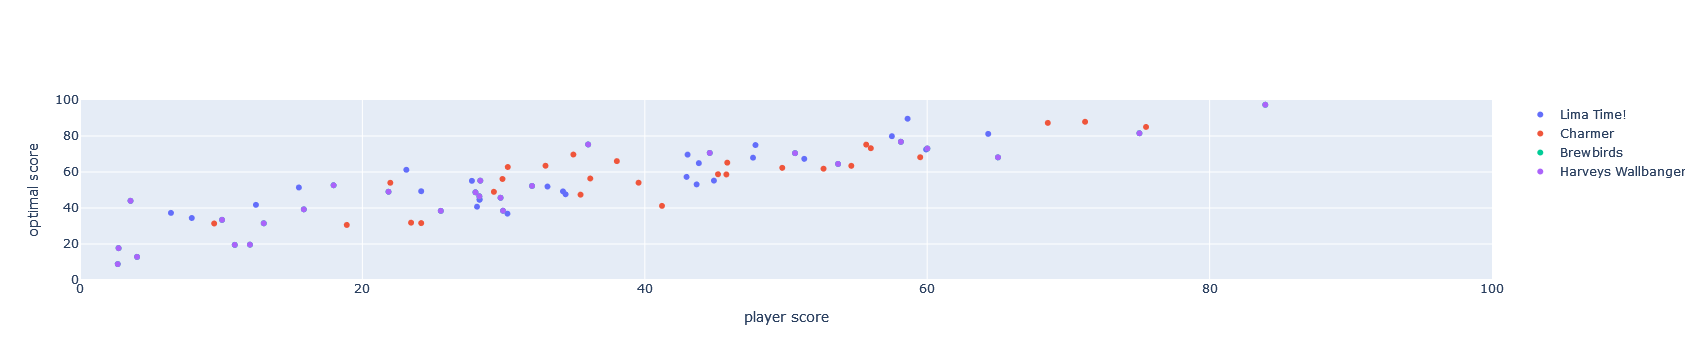

In [147]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        name='Lima Time!', x=lt.score, y=lt.optimal, mode='markers', text=lt.week
    )
)
fig.add_trace(
    go.Scatter(
        name='Charmer', x=ch.score, y=ch.optimal, mode='markers', text=ch.week
))
fig.add_trace(
    go.Scatter(
        name='Brewbirds', x=bb.score, y=bb.optimal, mode='markers', text=bb.week
))
fig.add_trace(
    go.Scatter(
        name='Harveys Wallbangers', x=bb.score, y=bb.optimal, mode='markers', text=bb.week
))
fig.update_layout(xaxis_title='player score', yaxis_title='optimal score',
                 yaxis_range=[0,100], xaxis_range=[0,100])
fig.show()

### Optimization Algorithm

In [14]:
from itertools import combinations, permutations, product
import numpy as np


class Optimized_Lineups:
    def __init__(self, owner, data, optimize_col='z'):
        self.owner = owner
        self.optimize_col = optimize_col
        self.data = data.sort_values(optimize_col, ascending=False)
        self.num_hitter_positions = 14
        self.d = self.data[self.data['Owner']==owner][['Player','all_pos', self.optimize_col, 'type']].set_index('Player').to_dict(orient='index')      
        self.p_dict = {k:v for (k,v) in self.d.items() if 'p' in v['type']}
        self.h_dict = {k:v for (k,v) in self.d.items() if 'h' in v['type']}
        self.catchers = [k for k,v in self.h_dict.items() if 'C\'' in v['all_pos']]#.replace('[','').replace(']','').replace('\'','').split(", ")
        self.first_basemen = [k for k,v in self.h_dict.items() if '1B' in v['all_pos']]
        self.second_basemen = [k for k,v in self.h_dict.items() if '2B' in v['all_pos']]
        self.third_basemen = [k for k,v in self.h_dict.items() if '3B' in v['all_pos']]
        self.shortstops = [k for k,v in self.h_dict.items() if 'SS' in v['all_pos']]
        self.middles = [k for k,v in self.h_dict.items() if 'MI' in v['all_pos']]
        self.corners = [k for k,v in self.h_dict.items() if 'CI' in v['all_pos']]
        self.outfielders = [k for k,v in self.h_dict.items() if 'OF' in v['all_pos']]
        self.dhs = [k for k,v in self.h_dict.items() if 'DH' in v['all_pos']]
        self.ofs = [i for i in combinations(self.outfielders, 5)]
        self.dh2 = [i for i in combinations(self.dhs, 2)]
        
    def _make_pitcher_combos(self):
        self.pitcher_combos = [i for i in combinations(self.p_dict.keys(), 9)]
        self.pitcher_z_list = self._z_list(self.pitcher_combos, self.p_dict)
        self.pitcher_idx = np.nanargmax(self.pitcher_z_list)
        self.pitcher_optimized_z = self.pitcher_z_list[self.pitcher_idx]
        self.pitcher_optimized_lineup = list(self.pitcher_combos[self.pitcher_idx])
        return
    
    def _z_list(self, pos_combos, player_dict):
        sum_z = 0
        z_list = []
        for i in range(len(pos_combos)):
            for name in pos_combos[i]:
                #print(i, sum_z)
                sum_z += player_dict[name][self.optimize_col]
            z_list.append(sum_z)
            sum_z = 0
        return z_list
    
    def _make_hitter_combos(self):
        position_combos = [i for i in product(self.catchers, self.first_basemen, self.second_basemen, self.shortstops, self.third_basemen, self.middles, self.corners, self.ofs)]
        max_z = -999
        max_z_idx = -1
        for num in range(len(position_combos)):
            list_z = sum([self.h_dict[name][self.optimize_col] for name in position_combos[num] if type(name)!=tuple]+[self.h_dict[item][self.optimize_col] for sublist in position_combos[num] for item in sublist if type(sublist)==tuple])
            if list_z > max_z and len(set(list(position_combos[num][0:-1])+list(position_combos[num][-1]))) == 12:
                    max_z = list_z
                    max_z_idx = num
        
        base_12 = list(set(list(position_combos[max_z_idx][0:-1])+list(position_combos[max_z_idx][-1])))
        self.hitter_optimized_lineup = list(position_combos[max_z_idx][0:-1])+list(position_combos[max_z_idx][-1])+[i for i in self.h_dict.keys() if i not in base_12][:2]
        self.hitter_optimized_z = self.data[self.data['Player'].isin(self.hitter_optimized_lineup)][self.optimize_col].sum()
        #_list = []
        #for num in range(len(inf)):
        #    _list.append([item for item in inf[num] if type(item)!=tuple]+[item for sublist in inf[num] for item in sublist if type(sublist)==tuple])
        
        #del(inf)
        #_list2 = [i for i in _list if len(set(i))==12]
        #del(_list)
        #inf2 = [i for i in product(_list2, self.dh2)]
        
        #del(_list2)
        #_list3 = []
        #for num in range(len(inf2)):
            #_list3.append([list(i) for i in inf2[num] if type(i)!=tuple][0]+[list(i) for i in inf2[num] if type(i)==tuple][0])
        #del(inf2)

        #self.hitter_combos = [i for i in _list3 if len(set(i))==self.num_hitter_positions]
        #print(len(self.hitter_combos))
        #self.hitter_z_list = self._z_list(self.hitter_combos, self.h_dict)
        #print(len(self.hitter_z_list))
        #self.hitter_idx = np.nanargmax(self.hitter_z_list)
        #self.hitter_optimized_z = self.hitter_z_list[self.hitter_idx]
        #self.hitter_optimized_lineup = self.hitter_combos[self.hitter_idx]
        return    

def stitch_positions(row):
    position_priority = ['C', '2B', '3B', 'SS', 'OF', '1B', 'MI', 'CI', 'DH', 'SP', 'RP']
    pos_code = row[position_priority+['P']]>=5
    return list(pos_code[pos_code].index)

In [16]:
yr = datetime.now().year
recent_week = 3
wk = pd.read_sql(f"SELECT max(week) week FROM projections WHERE year={yr}", conn).iloc[0]['week']

print(yr, wk)
proj  = pd.read_sql(f"""
    SELECT distinct 
        p.CBSNAME Player, o.owner Owner, o.owner_id, r.pos Decision, j.*, e.*, 
        CASE WHEN e.DH>=0 AND e.P=0 THEN 'h' ELSE 'p' END As type 
        FROM roster r 
        INNER JOIN projections j On (j.cbsid=r.cbsid) 
        INNER JOIN players p On (r.cbsid=p.cbsid) 
        INNER JOIN owners o On (r.owner_id=o.owner_id) 
        INNER JOIN (SELECT cbsid, all_pos, posC C, pos1B '1B', pos2B '2B', pos3B '3B', posSS SS, posOF OF, 
                        posDH DH, posSP SP, posRP RP, posP P FROM eligibility WHERE year={yr} and week={wk}) e 
                        On (r.cbsid=e.cbsid) 
        WHERE 
            j.year={yr} 
            AND j.week={wk} 
            AND j.proj_type='ros' 
            AND r.year={yr} 
            AND r.week={recent_week} 
        ORDER BY Owner, year, week""", conn)
proj.rename(columns={'Sv+Hld':'SvHld'}, inplace=True)
proj = proj.loc[:,~proj.columns.duplicated()].copy()
#proj.loc[proj['cbsid']==2942987, 'all_pos'] = 'SS,DH'
#proj.loc[proj['cbsid']==2167479, 'all_pos'] = 'OF,DH'
proj.loc[(proj['1B']>=5) | (proj['3B']>=5), 'CI'] = 5
proj.loc[(proj['2B']>=5) | (proj['SS']>=5), 'MI'] = 5
proj['all_pos'] = proj.apply(lambda x: stitch_positions(x), axis=1).apply(lambda y: ','.join(y))
df2 = proj.copy()
proj[proj['Owner']=='Lima Time!'].shape

2025 4


(30, 41)

In [19]:
ol = Optimized_Lineups('9 Grand Kids', proj)

In [22]:
ol._make_pitcher_combos()
ol.pitcher_optimized_lineup

['George Kirby',
 'Justin Steele',
 'Joe Ryan',
 'Josh Hader',
 'Edwin Diaz',
 'Seth Lugo',
 'Spencer Arrighetti',
 'Jacob deGrom',
 'Griffin Canning']

In [23]:
ol._make_hitter_combos()

IndexError: list index out of range

In [25]:
position_combos = [i for i in product(ol.catchers, ol.first_basemen, ol.second_basemen, ol.shortstops, ol.third_basemen, ol.middles, ol.corners, ol.ofs)]
max_z = -999
max_z_idx = -1

In [33]:
[k for k,v in ol.h_dict.items() if 'C\'' in v['all_pos']]

[]

In [44]:
for k,v in ol.h_dict.items():
    if 'C' in v['all_pos']:
        print(v)

{'all_pos': '3B,CI,DH', 'z': 3.0831517987927364, 'type': 'h'}
{'all_pos': 'C,1B,CI,DH', 'z': -1.0432424567324416, 'type': 'h'}
{'all_pos': 'C,2B,1B,MI,CI,DH', 'z': -3.4818122007229175, 'type': 'h'}
{'all_pos': '3B,CI,DH', 'z': -4.883598657287535, 'type': 'h'}


In [47]:
s = 'C,2B,1B,MI,CI,DH'
s.replace('[','').replace(']','').replace('\'','').split(",")

['C', '2B', '1B', 'MI', 'CI', 'DH']

In [41]:
[k for k,v in ol.h_dict.items() if 'C\'' in v['all_pos'].replace('[','').replace(']','').replace('\'','').split(", ")]

[]

In [35]:
[k for k,v in ol.h_dict.items() if '1B' in v['all_pos']]

['Salvador Perez', 'Connor Wong']

In [ ]:

for num in range(len(position_combos)):
    list_z = sum([self.h_dict[name][self.optimize_col] for name in position_combos[num] if type(name)!=tuple]+[self.h_dict[item][self.optimize_col] for sublist in position_combos[num] for item in sublist if type(sublist)==tuple])
    if list_z > max_z and len(set(list(position_combos[num][0:-1])+list(position_combos[num][-1]))) == 12:
            max_z = list_z
            max_z_idx = num

base_12 = list(set(list(position_combos[max_z_idx][0:-1])+list(position_combos[max_z_idx][-1])))
self.hitter_optimized_lineup = list(position_combos[max_z_idx][0:-1])+list(position_combos[max_z_idx][-1])+[i for i in self.h_dict.keys() if i not in base_12][:2]
self.hitter_optimized_z = self.data[self.data['Player'].isin(self.hitter_optimized_lineup)][self.optimize_col].sum()